# Group 18 Proposal - Credit card score and Education Levels



Dataset Link : http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

### Introduction:
When signing up for a credit card one receives a limit based on the card signed up for and credit score. Many struggle to manage their spendings, especially when financially independent. This is due to bills that need to be tracked if one is to pay off accrued credit card debt. Typically, those with higher education earn higher income and pay off credit card debt as well as having a higher credit limit. Those with lower education may earn less and struggle to pay back their debt while having a lower credit limit.
Can we predict a person's education based on how much of their credit limit they spend and how much they pay back?
We will use the "default of credit card clients Data Set" from UCI to answer this. Attributes included in the dataset are the amount of credit given, which includes an individual's credit limit, supplementary family credit, gender, education, marital status, age, payment history, amount of bill statement, and amount of previous payment.

### Preliminary exploratory data analysis:
- Demonstrate that the dataset can be read from the web into R 
- Clean and wrangle your data into a tidy format
- Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
- Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

In [ ]:
#### Dependencies and Packages:

In [1]:
# RUN THIS FIRST
install.packages('patchwork')
library(readxl)
library(tidyverse)
library(repr)
library(tidymodels)
library(patchwork)
set.seed(1234) # DO NOT CHANGE FOR RESULTS TO BE REPLICABLE

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔

#### Reading The Data From the Web:

In [7]:
# Data from Citation #1
temp <- tempfile()
download.file("http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls",temp)
credit <- read_excel(temp,skip = 1)
unlink(temp)

In [8]:
head(credit,n=3)

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20000,2,2,1,24,2,2,-1,-1,⋯,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


#### Cleaning and Wrangling Data:
- ```EDUCATION``` values can be observed to go up to 6, however they were only proper documentation in categorizing up to 4. Seeing as how 4 corresponds to "other" we have decided to only take education values from 1-3. \
Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- Some of the ```BILL_AMT``` vectors contained negative numbers. Negative balances are a rare occurence and only happen in strange circumstances so we will not be including them in our data set.
- ```BILL_AVG``` represents on average, throughout the six months what fraction of their credit limit has a person racked up in bills.
- Overall, the number of rows were reduced to 27636 from 30001 after cleaning and wrangling.

In [10]:
credit_rel <- credit %>%
    select(ID, LIMIT_BAL, EDUCATION, PAY_AMT1:PAY_AMT6, BILL_AMT1:BILL_AMT6) %>%
    filter(EDUCATION < 4, EDUCATION != 0) %>%
    filter_all(all_vars(. >= 0)) %>%
    mutate(PAY_AVG = (PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5 + PAY_AMT6)/6,
          BILL_AVG = (BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + BILL_AMT4 + BILL_AMT5 + BILL_AMT6)/6,
          BILL_AVG = BILL_AVG/LIMIT_BAL) %>%
    select(ID,EDUCATION, PAY_AVG, BILL_AVG)
credit_rel$EDUCATION <- as.factor(credit_rel$EDUCATION)
head(credit_rel,n=6)

ID,EDUCATION,PAY_AVG,BILL_AVG
<dbl>,<fct>,<dbl>,<dbl>
1,2,114.8333,0.06420000
2,2,833.3333,0.02371806
3,2,1836.3333,0.18824630
4,2,1398.0000,0.77111333
5,2,9841.5000,0.36446333
6,1,1295.3333,0.79371333


#### Scaling and Splitting the Data
- Since this dataset is sizeable (>27000 rows) the model is will be using a 60:40 training to testing split.
- Scaling data is important as this is a classification problem which uses distances between observations.

In [13]:
credit_scaled <- credit_rel %>%
    mutate(PAY_AVG = scale(PAY_AVG,center = TRUE),
          BILL_AVG = scale(BILL_AVG,center = TRUE))
credit_split <- initial_split(credit_rel, prop = 0.6, strata = EDUCATION)
credit_train <- training(credit_split)
credit_test <- testing(credit_split)


#### Tabular Exploratory Data Analysis:
Upon initial tabular exploration, we see that majority of people in this dataset have finished university, followed by graduate school, then high school graduates. It can be observed that on average, higher education correlating to higher ```PAY_AVG```  and lower ```BILL_AVG``` values, meaning they pay more expensive bills and spent a lower fraction of their credit limit respectively.

In [14]:
credit_edu <- credit_train %>%
    group_by(EDUCATION) %>%
    summarize(COUNT = n(), PAY_AVG = mean(PAY_AVG), BILL_AVG = mean(BILL_AVG))
credit_edu

`summarise()` ungrouping output (override with `.groups` argument)



EDUCATION,COUNT,PAY_AVG,BILL_AVG
<fct>,<int>,<dbl>,<dbl>
1,5811,6662.007,0.2967189
2,7982,4556.811,0.4419262
3,2789,4227.395,0.4505160


#### Visual Exploratory Data Analysis:
The visualization on the left tells us that a vast majority of people do not surpass their monthly credit limit, and most people spent between 0-10% of their credit limit. On the other hand, the plot on the right indicates that very few people pay over 4000 dollars back to their credit card company and vast majority pay less than 100 dollars.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



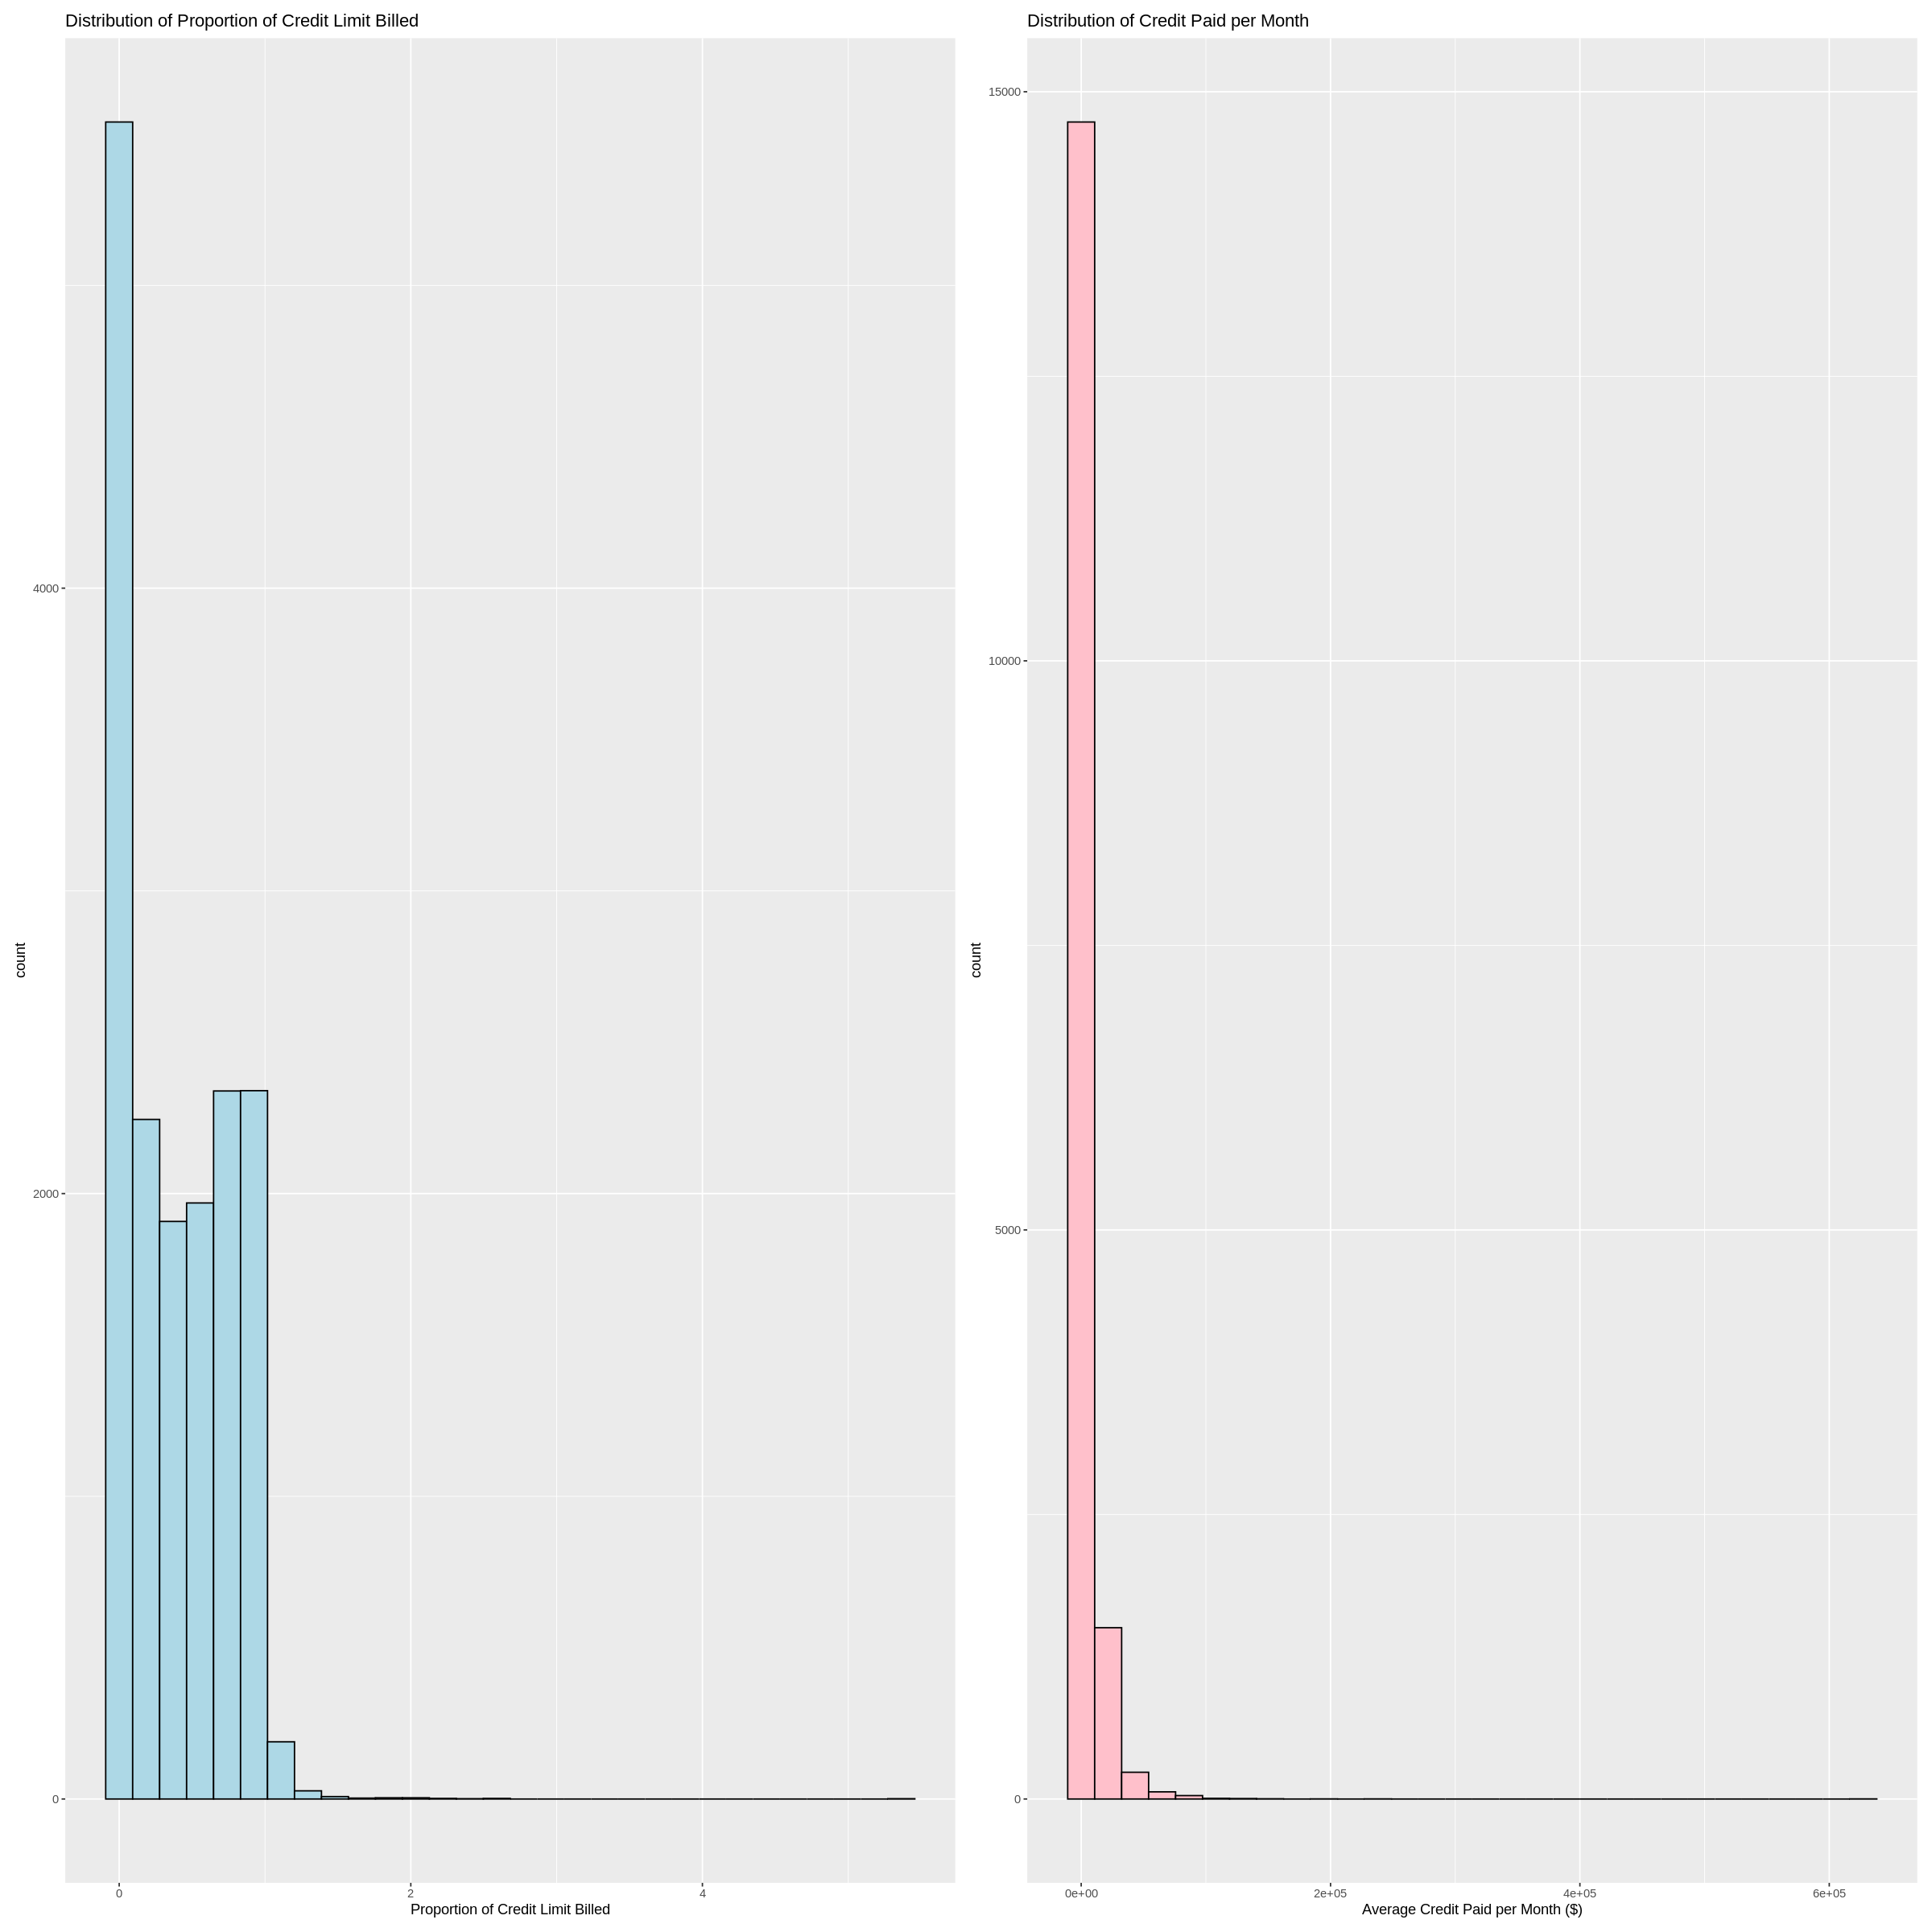

In [15]:
options(repr.plot.width = 20, repr.plot.height = 20)

bill_plot <- credit_train %>%
    ggplot(aes(x=BILL_AVG)) +
    geom_histogram(color='black',fill='light blue') +
    labs(x='Proportion of Credit Limit Billed') +
    ggtitle('Distribution of Proportion of Credit Limit Billed')
pay_plot <- credit_train %>%
    ggplot(aes(x=PAY_AVG)) +
    geom_histogram(color='black',fill='pink') +
    labs(x='Average Credit Paid per Month ($)') +
    ggtitle('Distribution of Credit Paid per Month')
bill_plot + pay_plot

#### Scaling The Data
- Scaling data is important as this is a classification problem which uses distances between observations. 

### Methods:
We are predicting the education level of an individual based on their credit history, looking at the average amount of credit used by the individual (NT dollars) relative to their credit limit and the average amount paid (NT dollars). We will use columns “LIMIT_BAL” and “BILL_AMT*” (* = 1 to 6) to create the predictor “bill_avg”. Also, “PAY_AMT*” (* = 1 to 6) to create the predictor “paid_avg”. We will center and scale the data to ensure the data is tidy. We will convert “EDUCATION” to a categorical variable. Since we have a sufficiently large dataset (30,000 instances), we decided to partition it to 60% training and 40% testing as we believe there is enough data to fit the most appropriate model and evaluate it. We will create a recipe that uses the two predictors, and centers and scales the training data. We proceed to create a model specification with tuning on the number of neighbors, and perform a 5-fold cross-validation. We will then create a workflow analysis that adds the recipe and model specification, defines the tuning to 10 K values, and collects the metrics. We will use a line plot k vs accuracy to visualize and evaluate which k to choose. We can now train the data again by specifying how many neighbors and create a new workflow. Finally, we will use the final model to predict on the testing dataset, calculate the accuracy and the confusion matrix. 

### Expected outcomes and significance:
We expect to find that individuals that spend less relative to their credit limit and pay back more will have higher education levels than those who spend more relative to their credit limit and pay back less. Verifying our prediction could highlight the importance of having an education and how it helps people maintain spending habits. Also, it could disclose information on the relationship between socioeconomic statuses and education. Furthermore,  one could investigate whether individuals with lower education levels will have a greater chance of struggling to repay debts in comparison to individuals with higher education levels. 

### Citations:
1. Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.